Based on the Time for Change Model (Abramowitz)

The *Time for Change* Model predicts the incumbent president's popular vote percentage
according to the following pieces of information:
- `NETAPP`	Incumbent president’s net approval rating (approval-dis-approval)
in the final Gallup Poll in June
- `G2GDP`	Annualized growth rate of real GDP in the second quarter of the election year
- `TERM1INC`	Presence (1) or absence (0) of a first-term incumbent in the race
- `A`	Constant = 47.26
- `V`	Incumbent share of the two-party presidential vote

## Vote equation
The model’s vote equation reads as:
```
V = A + 0.108 NETAPP + 0.543 Q2GDP + 4.313 TERM1INC
```

I believe that inflation also needs to be incorporated and that these coefficients might change in midterm years.

In [2]:
from time_for_change_data import load_compiled_time_for_change_data
compiled_data = load_compiled_time_for_change_data()

In [3]:
compiled_data['Incumbent'].sum()/len(compiled_data['Incumbent'])

0.6486486486486487

In [3]:
from bambi import Model, Prior
priors = {'Incumbent': Prior('Bernoulli', p=compiled_data['Incumbent'].sum()/len(compiled_data['Incumbent']))}
#model = Model('p(Result, n) ~ GDP + "Net Approval" + Incumbent', compiled_data, family='binomial')
model = Model('Result ~ GDP + "Net Approval" + Incumbent', compiled_data, priors=priors, dropna=True)
model

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
Automatically removing 18/37 rows from the dataset.


Formula: Result ~ GDP + "Net Approval" + Incumbent
Family name: Gaussian
Link: identity
Observations: 19
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 51.6842, sigma: 17.1472)
    GDP ~ Normal(mu: 0.0, sigma: 3.5815)
    Net Approval ~ Normal(mu: 0.0, sigma: 0.5082)
    Incumbent ~ Bernoulli(p: 0.6486)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 5.0477)

In [4]:
model_results = model.fit(draws=5000)
model_results

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [Result_sigma, Net Approval, GDP, Intercept]
>BinaryGibbsMetropolis: [Incumbent]


/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 10 seconds.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'GDP'}>,
        <AxesSubplot:title={'center':'Net Approval'}>],
       [<AxesSubplot:title={'center':'Incumbent'}>,
        <AxesSubplot:title={'center':'Result_sigma'}>, <AxesSubplot:>]],
      dtype=object)

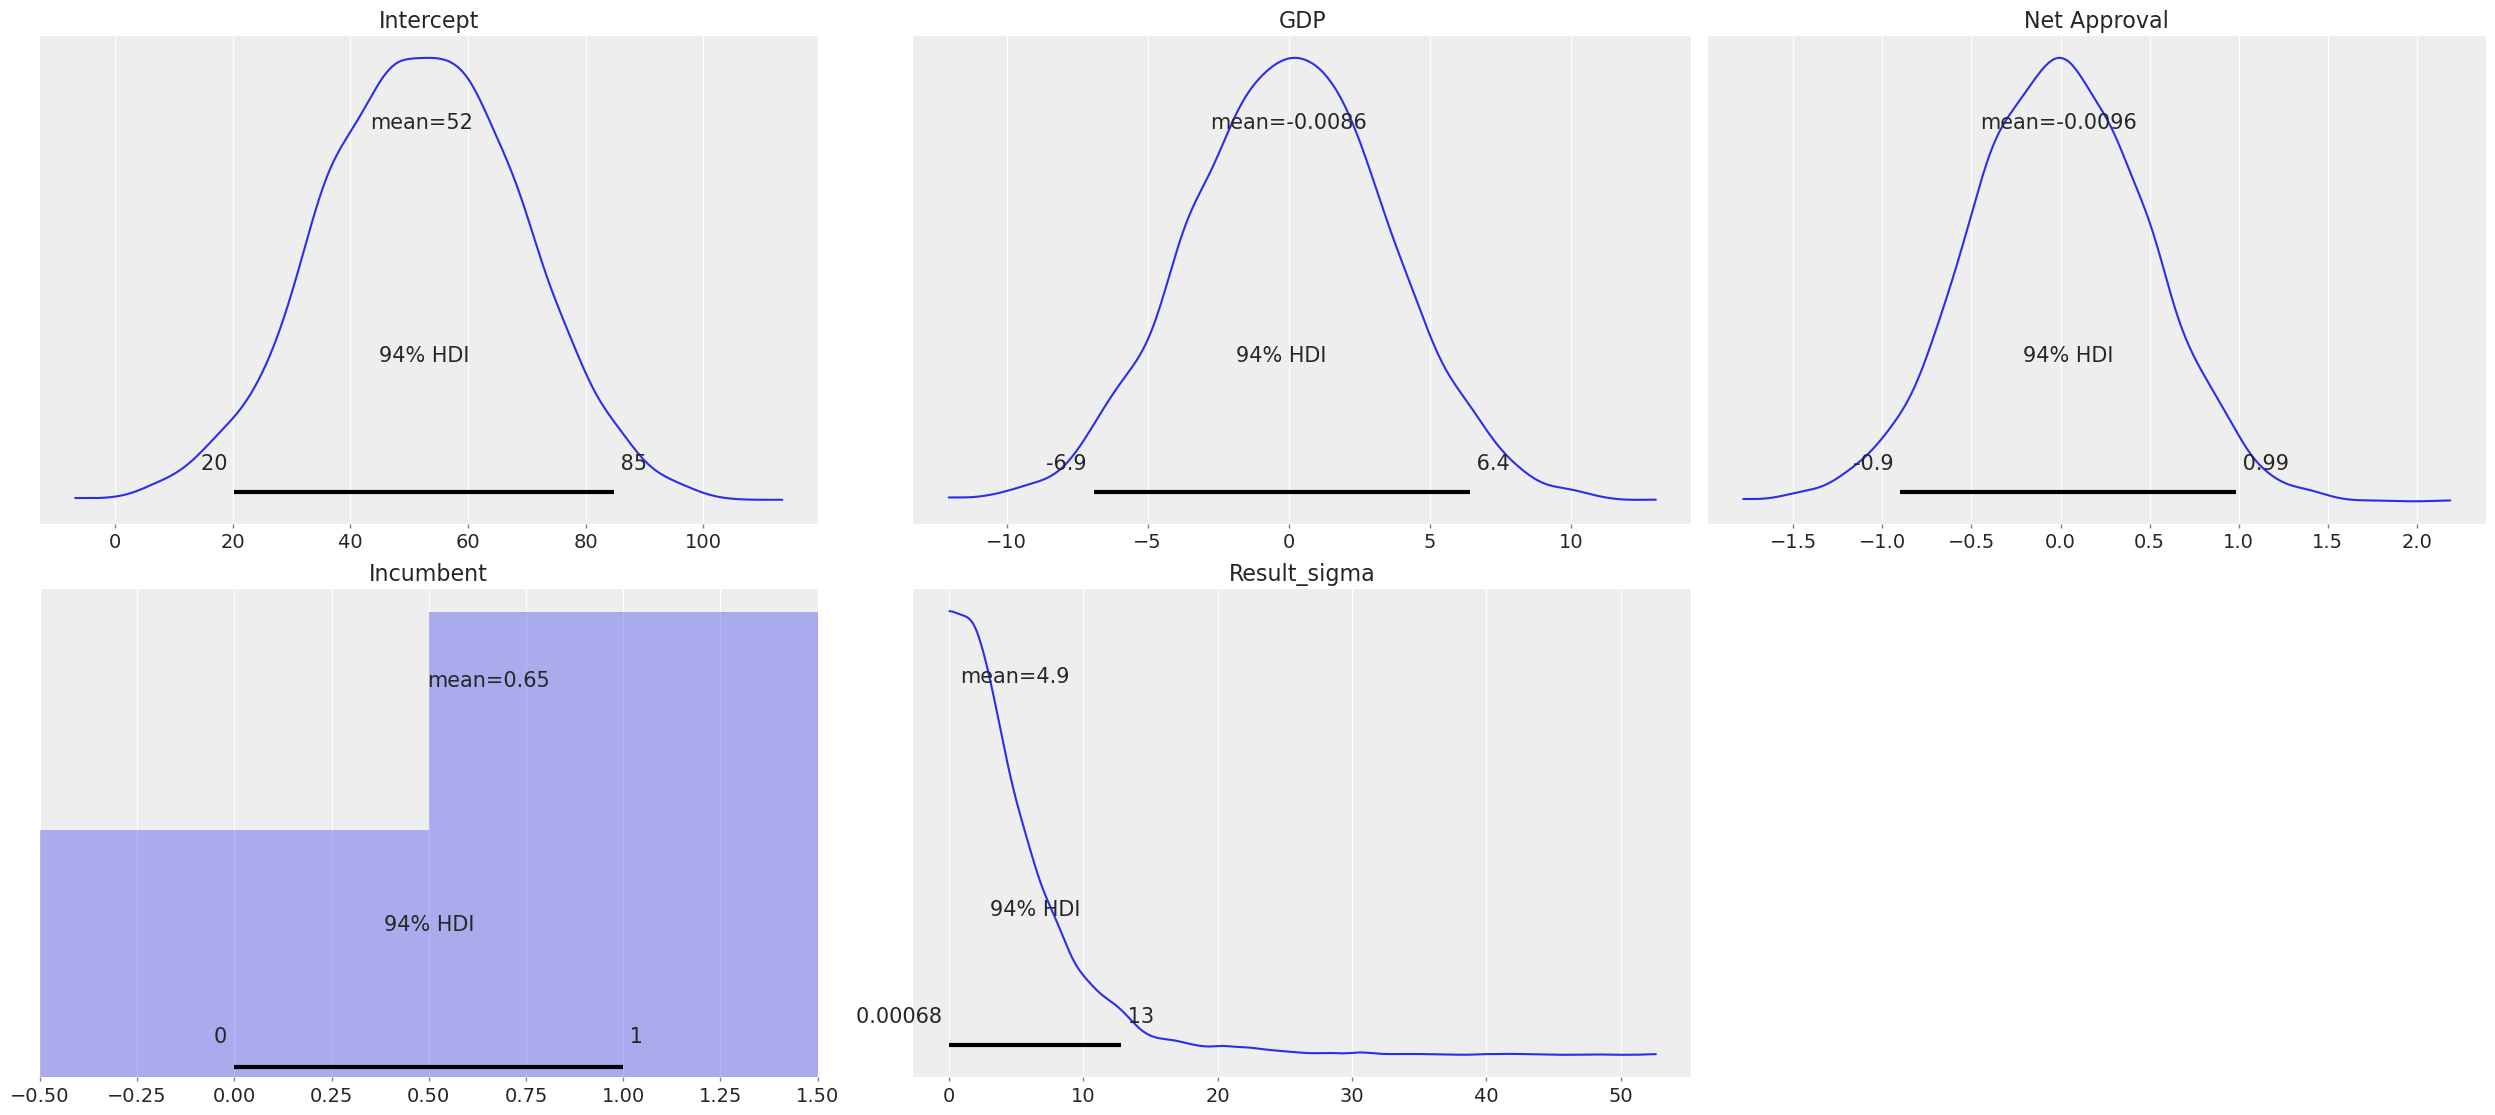

In [5]:
import arviz as az
az.style.use('arviz-darkgrid')
model.plot_priors()

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'GDP'}>,
        <AxesSubplot:title={'center':'GDP'}>],
       [<AxesSubplot:title={'center':'Net Approval'}>,
        <AxesSubplot:title={'center':'Net Approval'}>],
       [<AxesSubplot:title={'center':'Incumbent'}>,
        <AxesSubplot:title={'center':'Incumbent'}>],
       [<AxesSubplot:title={'center':'Result_sigma'}>,
        <AxesSubplot:title={'center':'Result_sigma'}>]], dtype=object)

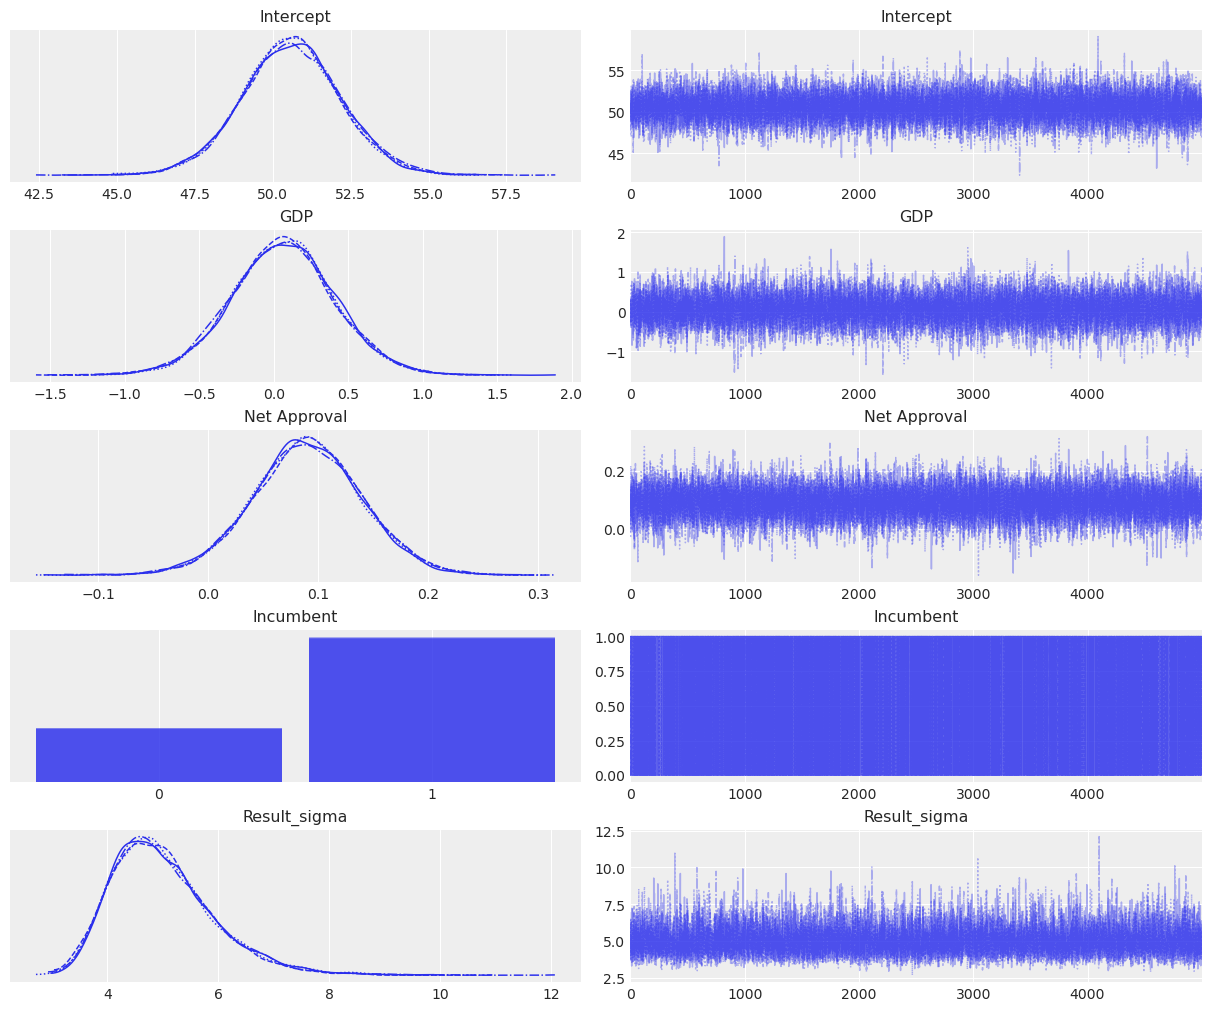

In [6]:
az.plot_trace(model_results)

In [7]:
summary = az.summary(model_results)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,50.581,1.593,47.575,53.600,0.012,0.008,18387.0,13465.0,1.0
GDP,0.062,0.350,-0.599,0.715,0.003,0.003,15616.0,13158.0,1.0
Net Approval,0.090,0.050,-0.002,0.186,0.000,0.000,16692.0,12579.0,1.0
Incumbent,0.729,0.445,0.000,1.000,0.003,0.002,24037.0,20000.0,1.0
Result_sigma,5.000,0.924,3.444,6.730,0.008,0.006,13867.0,12048.0,1.0


## Vote equation
The model’s vote equation reads as:
```
V = A + 0.108 NETAPP + 0.543 Q2GDP + 4.313 TERM1INC
A = 47.26
```



In [8]:
summary['mean']

Intercept       50.581
GDP              0.062
Net Approval     0.090
Incumbent        0.729
Result_sigma     5.000
Name: mean, dtype: float64

In [9]:
means = summary['mean']
compiled_data['Updated Prediction'] = means['Intercept'] + means['GDP']*compiled_data['GDP'] +means['Net Approval']*compiled_data['Net Approval'] + means['Incumbent']*compiled_data['Incumbent']

compiled_data['Updated Prediction']

1948    50.504794
1950    50.862436
1952    49.193288
1954    54.579339
1956    56.408933
1958    53.245859
1960    53.408609
1962    56.227117
1964    57.003207
1966    52.584389
1968    51.021966
1970    53.480096
1972    53.705822
1974    47.868078
1976    51.413701
1978    51.686845
1980    48.831946
1982    51.067345
1984    53.245795
1986    54.230498
1988    51.579045
1990    56.139592
1992    49.976525
1994    51.301975
1996    52.458132
1998    53.174935
2000    52.256170
2002    56.522019
2004    51.482558
2006    48.695591
2008    47.066568
2010    51.581503
2012    51.547177
2014    49.923024
2016    51.205793
2018    50.344361
2020    49.576808
Name: Updated Prediction, dtype: float64

In [10]:
from sklearn.metrics import mean_squared_error
result_not_null = compiled_data[compiled_data['Result'].notnull()]
tfc_mse = mean_squared_error(result_not_null['Result'], result_not_null['Time For Change Prediction'], squared=False)
updated_mse = mean_squared_error(result_not_null['Result'], result_not_null['Updated Prediction'], squared=False)
print({'Time for Change': tfc_mse, 'Updated Prediction': updated_mse})

{'Time for Change': 4.773923703903969, 'Updated Prediction': 4.382442348917892}


Our updated model is *slightly* more accurate, but note that the original model is within the confidence interval of ours.

In [ ]:
compiled_data['Avg Inflation']

In [ ]:
from bambi import Model, Prior
def normal_prior(name):
    return Prior('Normal', mu=compiled_data[name].mean(), sigma=compiled_data[name].std())

inflation_priors = {'Incumbent': Prior('Bernoulli', p=compiled_data['Incumbent'].sum()/len(compiled_data['Incumbent'])),
                    'GDP': normal_prior('GDP'),
                    "Net Approval": normal_prior("Net Approval"),
                    'Avg Inflation': normal_prior('Avg Inflation'),
                    }
#model = Model('p(Result, n) ~ GDP + "Net Approval" + Incumbent', compiled_data, family='binomial')
inflation_model = Model('Result ~ GDP + "Net Approval" + Incumbent + "Avg Inflation"', compiled_data, priors=inflation_priors, dropna=True, family='t')
print(inflation_model)
inflation_model_results = inflation_model.fit(draws=5000)
print(inflation_model_results)
inflation_model.plot_priors()
az.plot_trace(inflation_model_results)
inflation_summary = az.summary(inflation_model_results)
inflation_summary

In [ ]:
inflation_means = inflation_summary['mean']
compiled_data['Inflation Prediction'] = inflation_means['Intercept'] + inflation_means['GDP']*compiled_data['GDP'] +inflation_means['Net Approval']*compiled_data['Net Approval'] + inflation_means['Incumbent']*compiled_data['Incumbent']

compiled_data['Inflation Prediction']

In [ ]:
from sklearn.metrics import mean_squared_error
result_not_null = compiled_data[compiled_data['Result'].notnull()]
tfc_mse = mean_squared_error(result_not_null['Result'], result_not_null['Time For Change Prediction'], squared=False)
updated_mse = mean_squared_error(result_not_null['Result'], result_not_null['Inflation Prediction'], squared=False)
print({'Time for Change': tfc_mse, 'Inflation Prediction': updated_mse})

Clearly, inflation does not help us predict better using a bayesian linear model.

Not shown here are some manipulations on inflation experimenting to see if they make a better prior.

All are equally bad or worse.


# House percentage (Including Mid-term election results)
Obviously, there are no presidential elections in mid-term years (hence "mid-term"). To overcome this, we will
predict the percentage of house seats won based on the same priors as above.

In [ ]:
house_tfc_priors = {'Incumbent': Prior('Bernoulli', p=compiled_data['Incumbent'].sum()/len(compiled_data['Incumbent'])),
                    'GDP': normal_prior('GDP'),
                    "Net Approval": normal_prior("Net Approval"),
                    'Midterm Year': Prior('Bernoulli', p=.5),
                    }
#model = Model('p(Result, n) ~ GDP + "Net Approval" + Incumbent', compiled_data, family='binomial')
house_tfc_model = Model('"House Incumbent Percent" ~ GDP + "Net Approval" + Incumbent + "Midterm Year"', compiled_data, priors=house_tfc_priors, dropna=True)
print(house_tfc_model)
house_tfc_model_results = house_tfc_model.fit(draws=5000)
print(house_tfc_model_results)
house_tfc_model.plot_priors()
az.plot_trace(house_tfc_model_results)
house_tfc_summary = az.summary(house_tfc_model_results)
house_tfc_summary

In [ ]:
house_tfc_means = house_tfc_summary['mean']
compiled_data['House TFC Learned Prediction'] = house_tfc_means['Intercept'] + house_tfc_means['GDP']*compiled_data['GDP'] +house_tfc_means['Net Approval']*compiled_data['Net Approval'] + house_tfc_means['Incumbent']*compiled_data['Incumbent']

compiled_data['House TFC Learned Prediction'].head()

In [ ]:
from sklearn.metrics import mean_squared_error
naive_house_tfc_mse = mean_squared_error(compiled_data['House Incumbent Percent'], compiled_data['Time For Change Prediction'], squared=False)
learned_house_tfc_mse = mean_squared_error(compiled_data['House Incumbent Percent'], compiled_data['House TFC Learned Prediction'], squared=False)
print({'Naive House Time for Change': naive_house_tfc_mse, 'Learned House Time for Change': learned_house_tfc_mse})

Our learned house model is definitely more accurate than just the naive House Time for Change model,
but its mean squared error is half as good as our presidential model's.

That being said, the US House election is not one singular, popular vote election in the
same sense as the computation of the US President Popular Vote.
I suspect we could jointly train 435 separate models (one for each house district) and get
fairly accurate predictions in each.

The only problem with that is that I need A LOT more district-level data from a lot more years.
This also needs a way to generalize the model between decades, since house districts are different
everytime redistricting occurs.

As a Proof of concept, I guess I could just use data from every house election between 2012-2020.

# House district model

In [1]:
import pandas as pd
from time_for_change_data import load_congressional_time_for_change_data
congressional_district_data = load_congressional_time_for_change_data()

In [19]:
from bambi import Model, Prior
def normal_prior(name):
    return Prior('Normal', mu=congressional_district_data[name].mean(), sigma=congressional_district_data[name].std())
def bernoulli_prior(name):
    return Prior('Bernoulli', p=congressional_district_data[name].sum()/len(congressional_district_data[name]))

congressional_district_data_priors = {'Incumbent': bernoulli_prior('Incumbent'),
                    'GDP': normal_prior('GDP'),
                    "Net Approval": normal_prior("Net Approval"),
                    'PartiesMatch': bernoulli_prior('PartiesMatch')
                    }
#model = Model('p(Result, n) ~ GDP + "Net Approval" + Incumbent', compiled_data, family='binomial')
house_district_model = Model('IncumbentResult ~ GDP + ((Incumbent + "Net Approval") * PartiesMatch)',
                             congressional_district_data,
                             priors=congressional_district_data_priors,
                             dropna=True,
                             family='t')
print(house_district_model)
house_district_model_results = house_district_model.fit(draws=3000)
print(house_district_model_results)


WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
Automatically removing 100/4350 rows from the dataset.


Formula: IncumbentResult ~ GDP + ((Incumbent + "Net Approval") * PartiesMatch)
Family name: T
Link: identity
Observations: 4250
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 65.98, sigma: 42.6145)
    GDP ~ Normal(mu: 1.3248, sigma: 3.5832)
    Incumbent ~ Bernoulli(p: 0.6)
    Net Approval ~ Normal(mu: -3.4, sigma: 23.9201)
    PartiesMatch ~ Bernoulli(p: 0.4885)
    Incumbent:PartiesMatch ~ Normal(mu: 0.0, sigma: 76.5969)
    Net Approval:PartiesMatch ~ Normal(mu: 0.0, sigma: 2.0809)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 14.1389)
    nu ~ Gamma(alpha: 2, beta: 0.1)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [IncumbentResult_nu, IncumbentResult_sigma, Net Approval:PartiesMatch, Incumbent:PartiesMatch, Net Approval, GDP, Intercept]
>BinaryGibbsMetropolis: [Incumbent, PartiesMatch]


/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 33 seconds.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,65.520,0.311,64.968,66.132,0.003,0.002,9477.0,9222.0,1.0
GDP,0.090,0.050,-0.004,0.185,0.000,0.000,12175.0,9387.0,1.0
Incumbent,0.848,0.359,0.000,1.000,0.005,0.003,6212.0,6212.0,1.0
Net Approval,-0.047,0.012,-0.069,-0.025,0.000,0.000,9171.0,8631.0,1.0
PartiesMatch,0.000,0.020,0.000,0.000,0.000,0.000,8583.0,8583.0,1.0
Incumbent:PartiesMatch,-4.278,0.450,-5.119,-3.416,0.005,0.003,9690.0,8905.0,1.0
Net Approval:PartiesMatch,0.187,0.016,0.157,0.216,0.000,0.000,9905.0,7911.0,1.0
IncumbentResult_sigma,9.953,0.223,9.533,10.368,0.002,0.002,10115.0,8846.0,1.0
IncumbentResult_nu,3.685,0.261,3.212,4.178,0.003,0.002,9744.0,8529.0,1.0


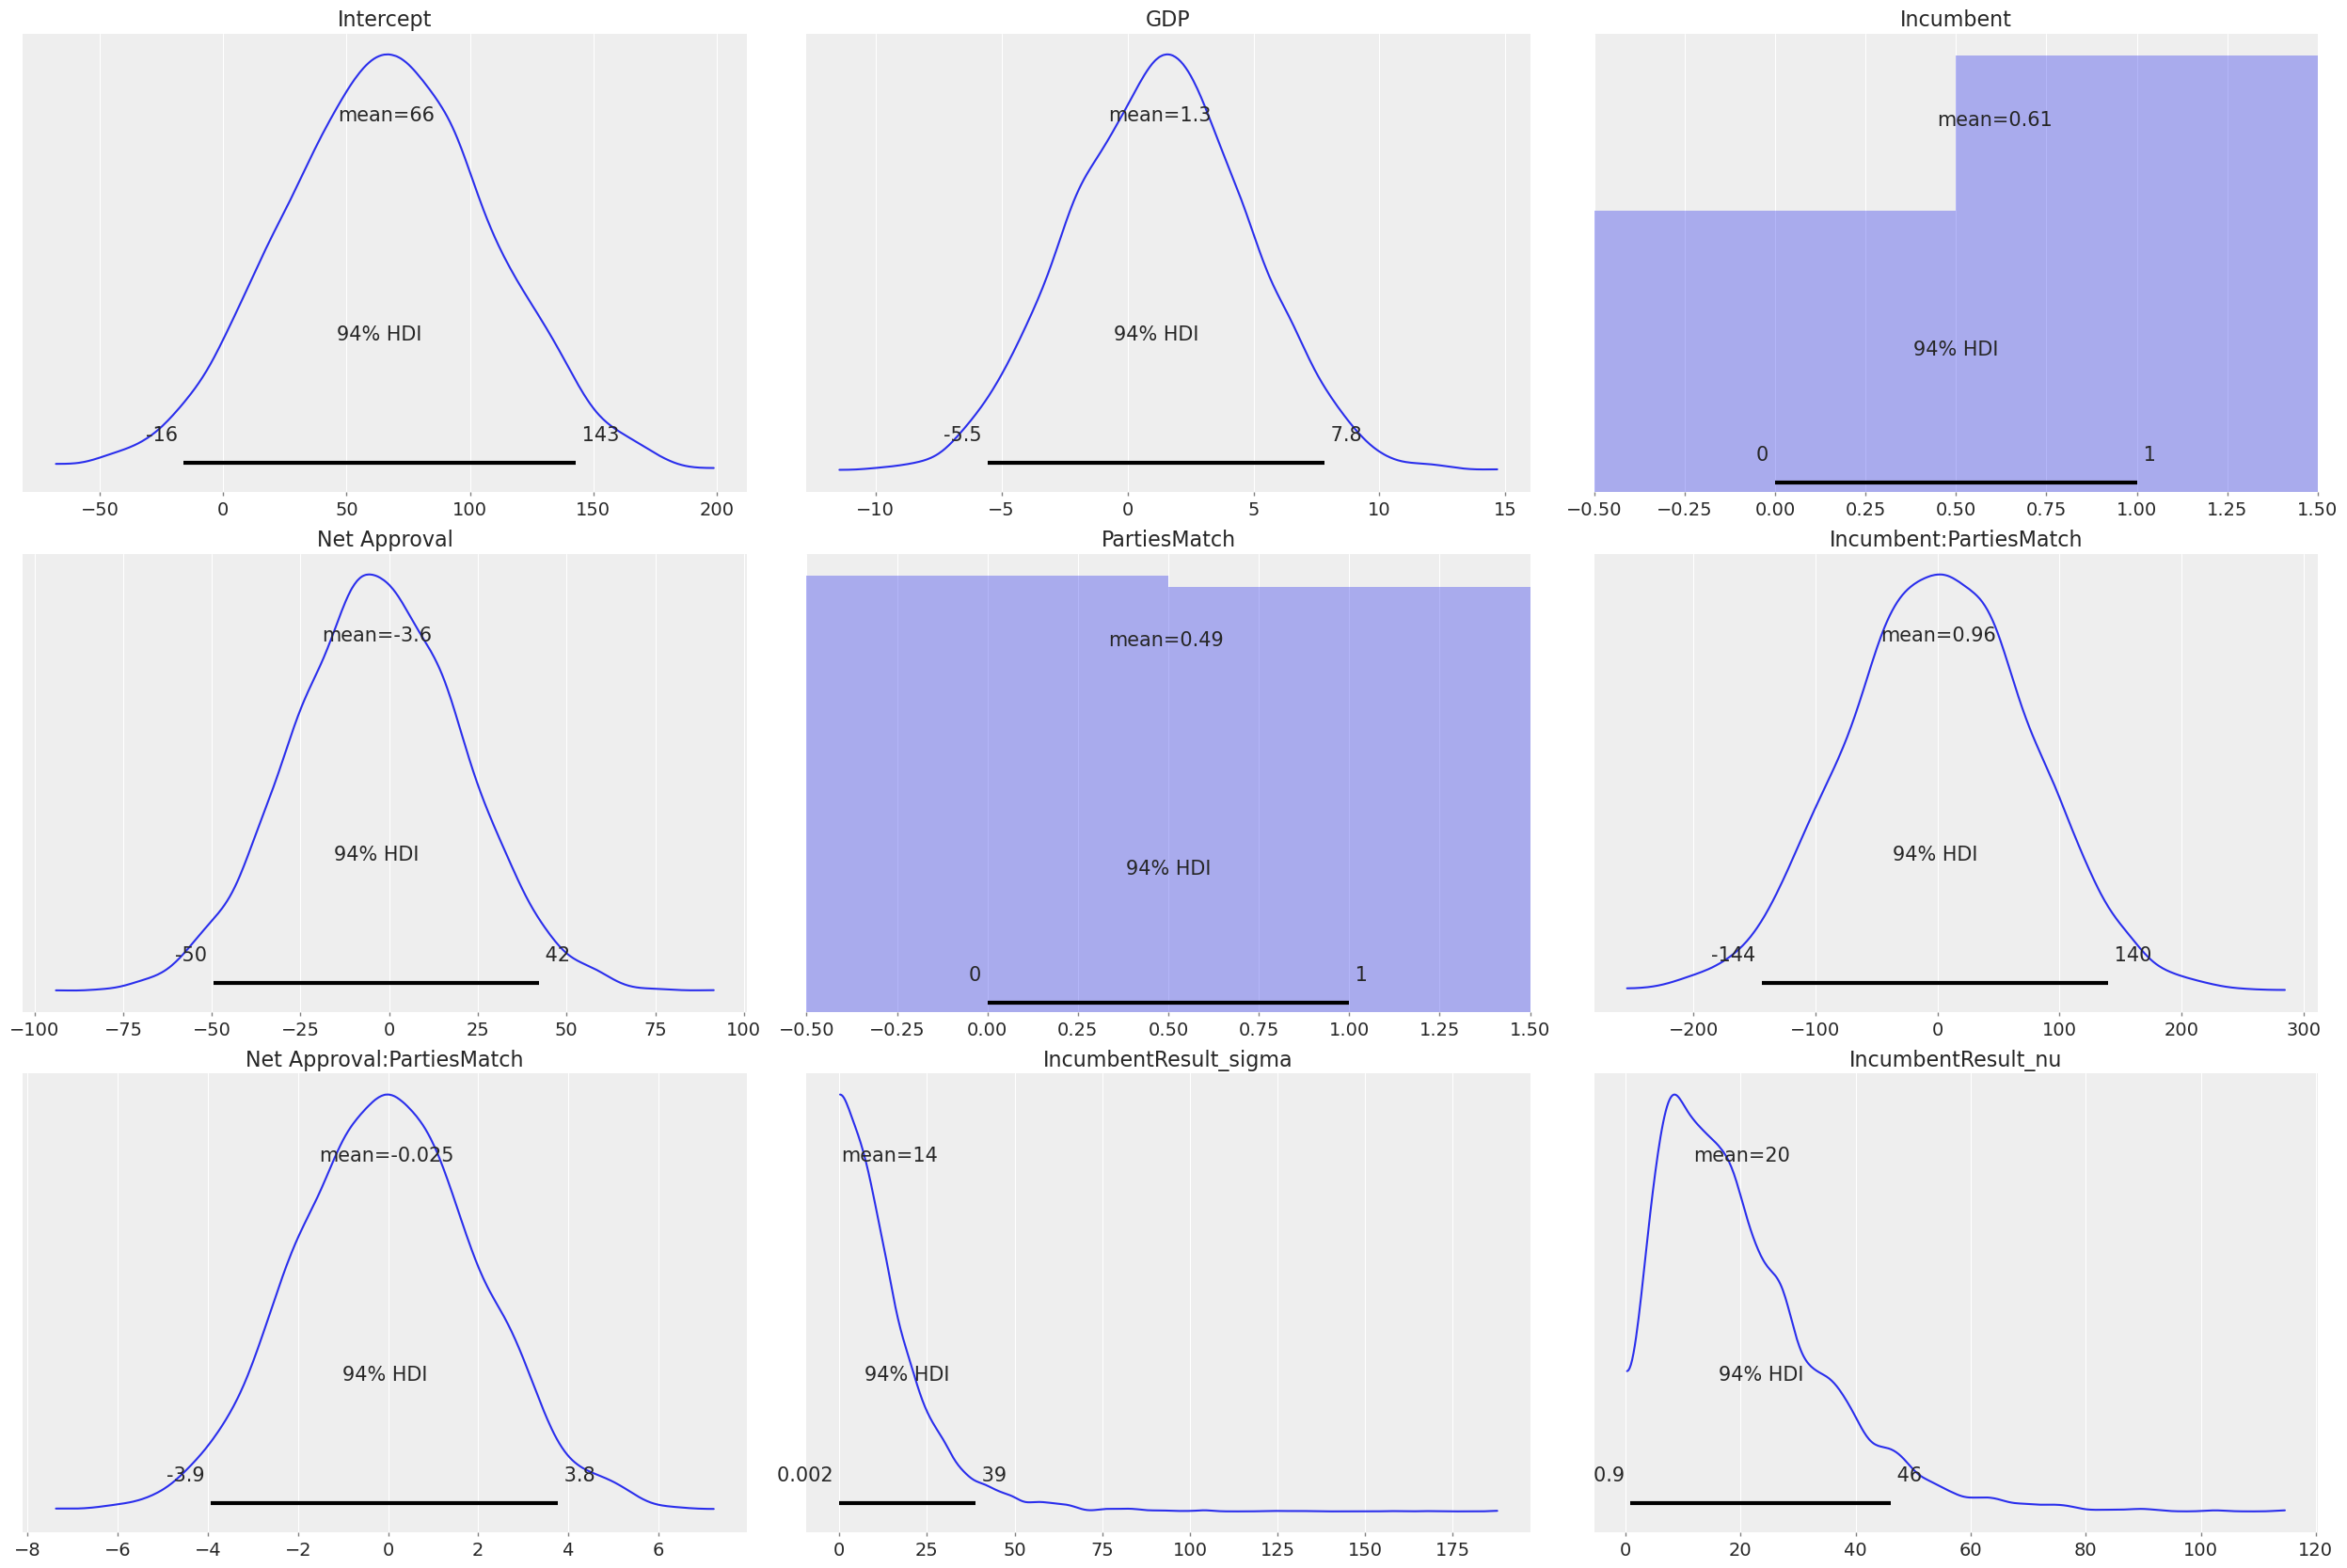

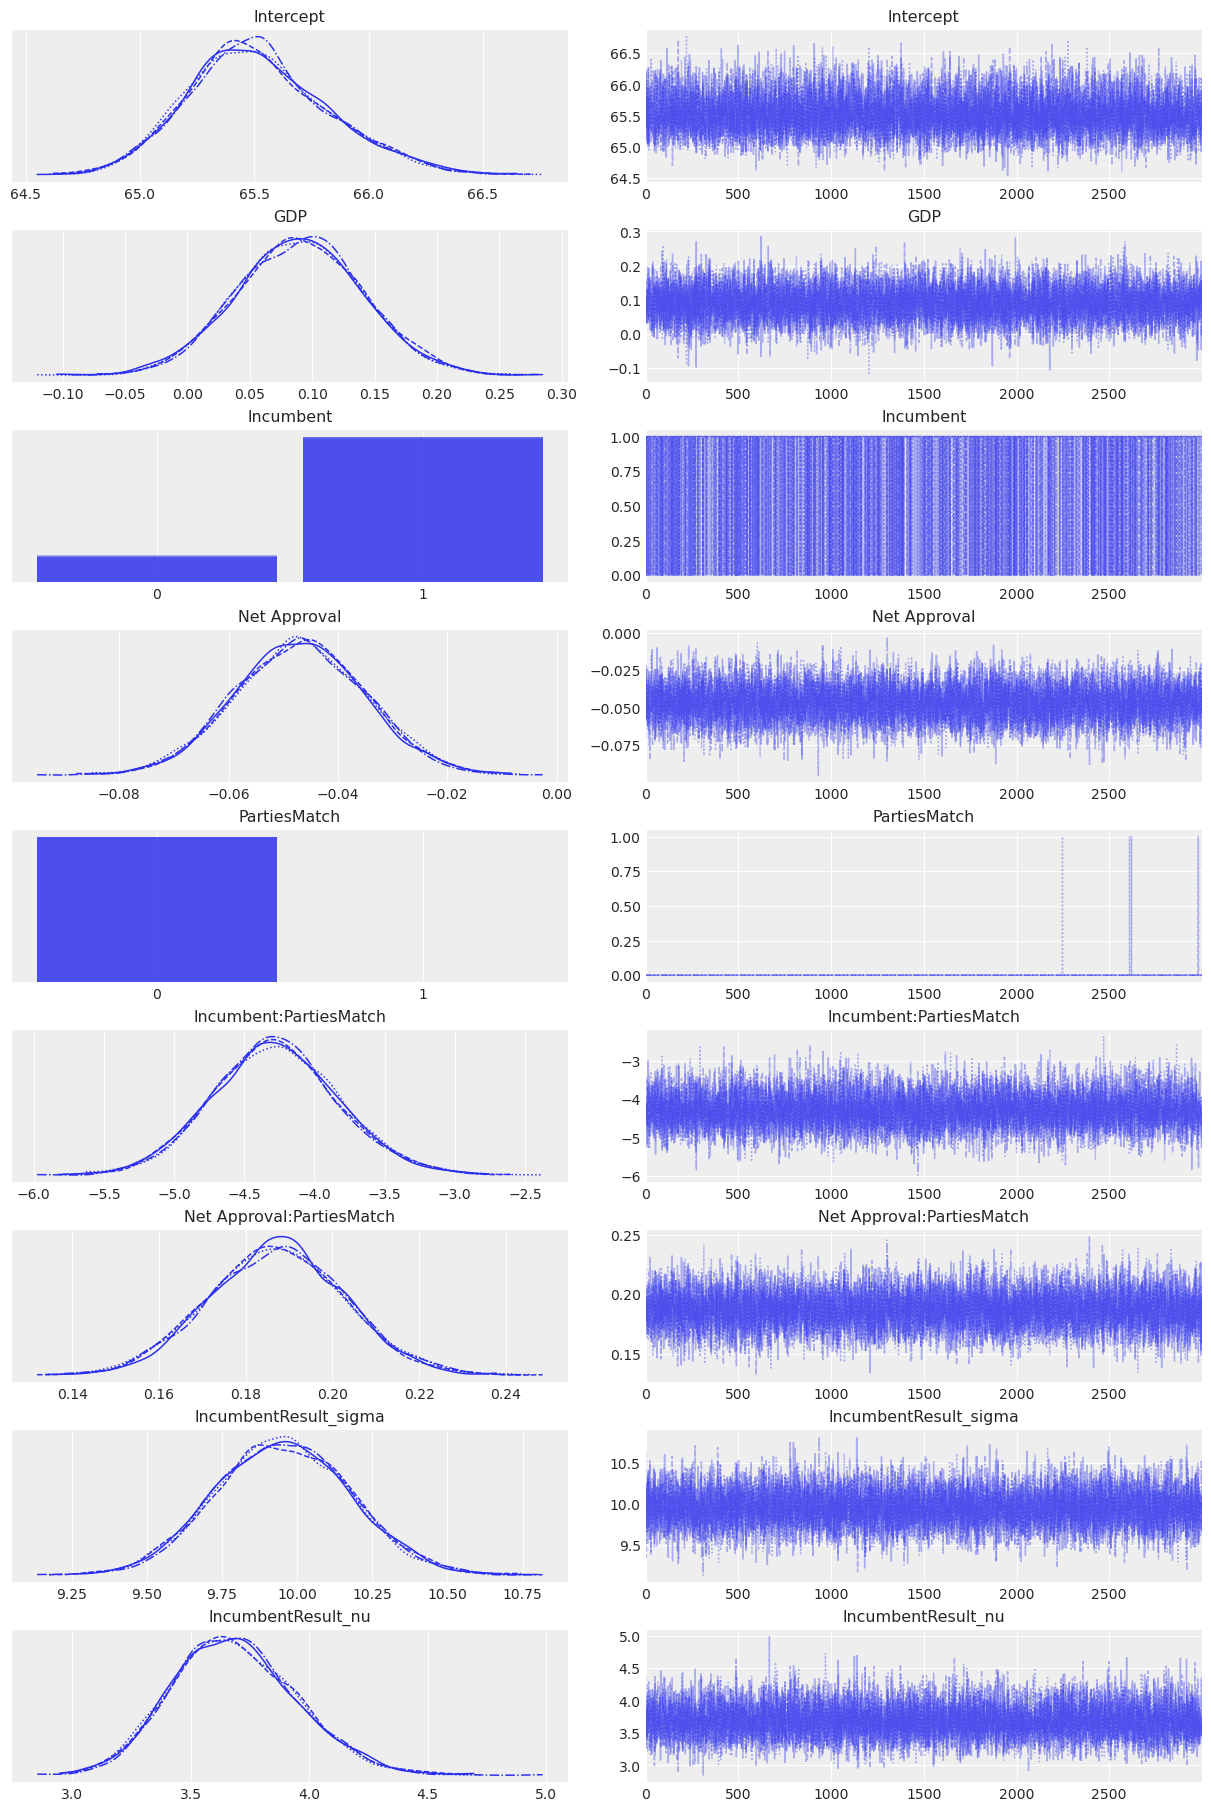

In [20]:
import arviz as az
az.style.use('arviz-darkgrid')
house_district_model.plot_priors()
az.plot_trace(house_district_model_results)
house_district_model_summary = az.summary(house_district_model_results)
house_district_model_summary

In [21]:
house_district_model_results


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

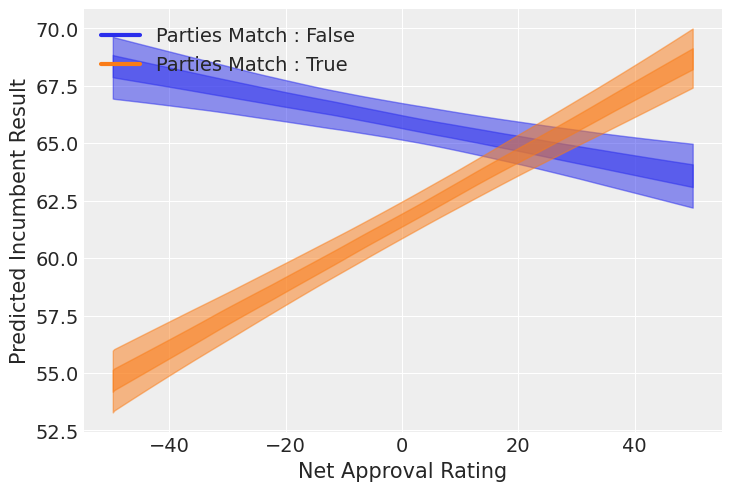

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

APPROVAL = np.linspace(-50, 50)


fig, ax = plt.subplots()
handles = []


for i in range(2):
    color = f"C{i}"
    label = f"Parties Match : {bool(i)}"
    handles.append(mlines.Line2D([], [], color=color, label=label, lw=3))

    new_data = pd.DataFrame({
           'GDP': np.ones_like(APPROVAL) * (congressional_district_data['GDP'].mean()-6),
           'Incumbent': np.ones_like(APPROVAL) * 1,
           'Net Approval': APPROVAL,
           'PartiesMatch': np.ones_like(APPROVAL) * i
    })
    new_idata_house = house_district_model.predict(house_district_model_results, data=new_data, inplace=False)
    mean = new_idata_house.posterior["IncumbentResult_mean"].values

    az.plot_hdi(APPROVAL, mean, ax=ax, color=color)
    az.plot_hdi(APPROVAL, mean, ax=ax, color=color, hdi_prob=0.5)

ax.set_xlabel("Net Approval Rating")
ax.set_ylabel("Predicted Incumbent Result")
ax.legend(handles=handles, loc="upper left")

# House District Classification
Let's do a classification model instead, since for house races, that is what we care about most--who won, not by what margin.

In [23]:
house_district_classifier_model = Model('HouseIncumbentWon ~ GDP + ((Incumbent + "Net Approval") * PartiesMatch)',
                             congressional_district_data,
                             priors=congressional_district_data_priors,
                             dropna=True,
                             family='bernoulli')
print(house_district_classifier_model)
house_district_classifier_model_results = house_district_classifier_model.fit(draws=3000)
print(house_district_classifier_model_results )

Formula: HouseIncumbentWon ~ GDP + ((Incumbent + "Net Approval") * PartiesMatch)
Family name: Bernoulli
Link: logit
Observations: 4350
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 3.0002)
    GDP ~ Normal(mu: 1.3248, sigma: 3.5832)
    Incumbent ~ Bernoulli(p: 0.6)
    Net Approval ~ Normal(mu: -3.4, sigma: 23.9201)
    PartiesMatch ~ Bernoulli(p: 0.4885)
    Incumbent:PartiesMatch ~ Normal(mu: 0.0, sigma: 5.4495)
    Net Approval:PartiesMatch ~ Normal(mu: 0.0, sigma: 0.1488)


Modeling the probability that HouseIncumbentWon==1
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [Net Approval:PartiesMatch, Incumbent:PartiesMatch, Net Approval, GDP, Intercept]
>BinaryGibbsMetropolis: [Incumbent, PartiesMatch]


/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 32 seconds.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data


/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.330,0.069,2.203,2.464,0.001,0.001,9198.0,8549.0,1.0
GDP,-0.022,0.014,-0.049,0.005,0.000,0.000,13560.0,9828.0,1.0
Incumbent,0.000,0.000,0.000,0.000,0.000,0.000,12000.0,12000.0,NaN
Net Approval,-0.011,0.003,-0.016,-0.005,0.000,0.000,8530.0,9544.0,1.0
PartiesMatch,0.000,0.000,0.000,0.000,0.000,0.000,12000.0,12000.0,NaN
Incumbent:PartiesMatch,-0.400,0.105,-0.587,-0.196,0.001,0.001,12029.0,9231.0,1.0
Net Approval:PartiesMatch,0.029,0.004,0.021,0.037,0.000,0.000,7562.0,9051.0,1.0


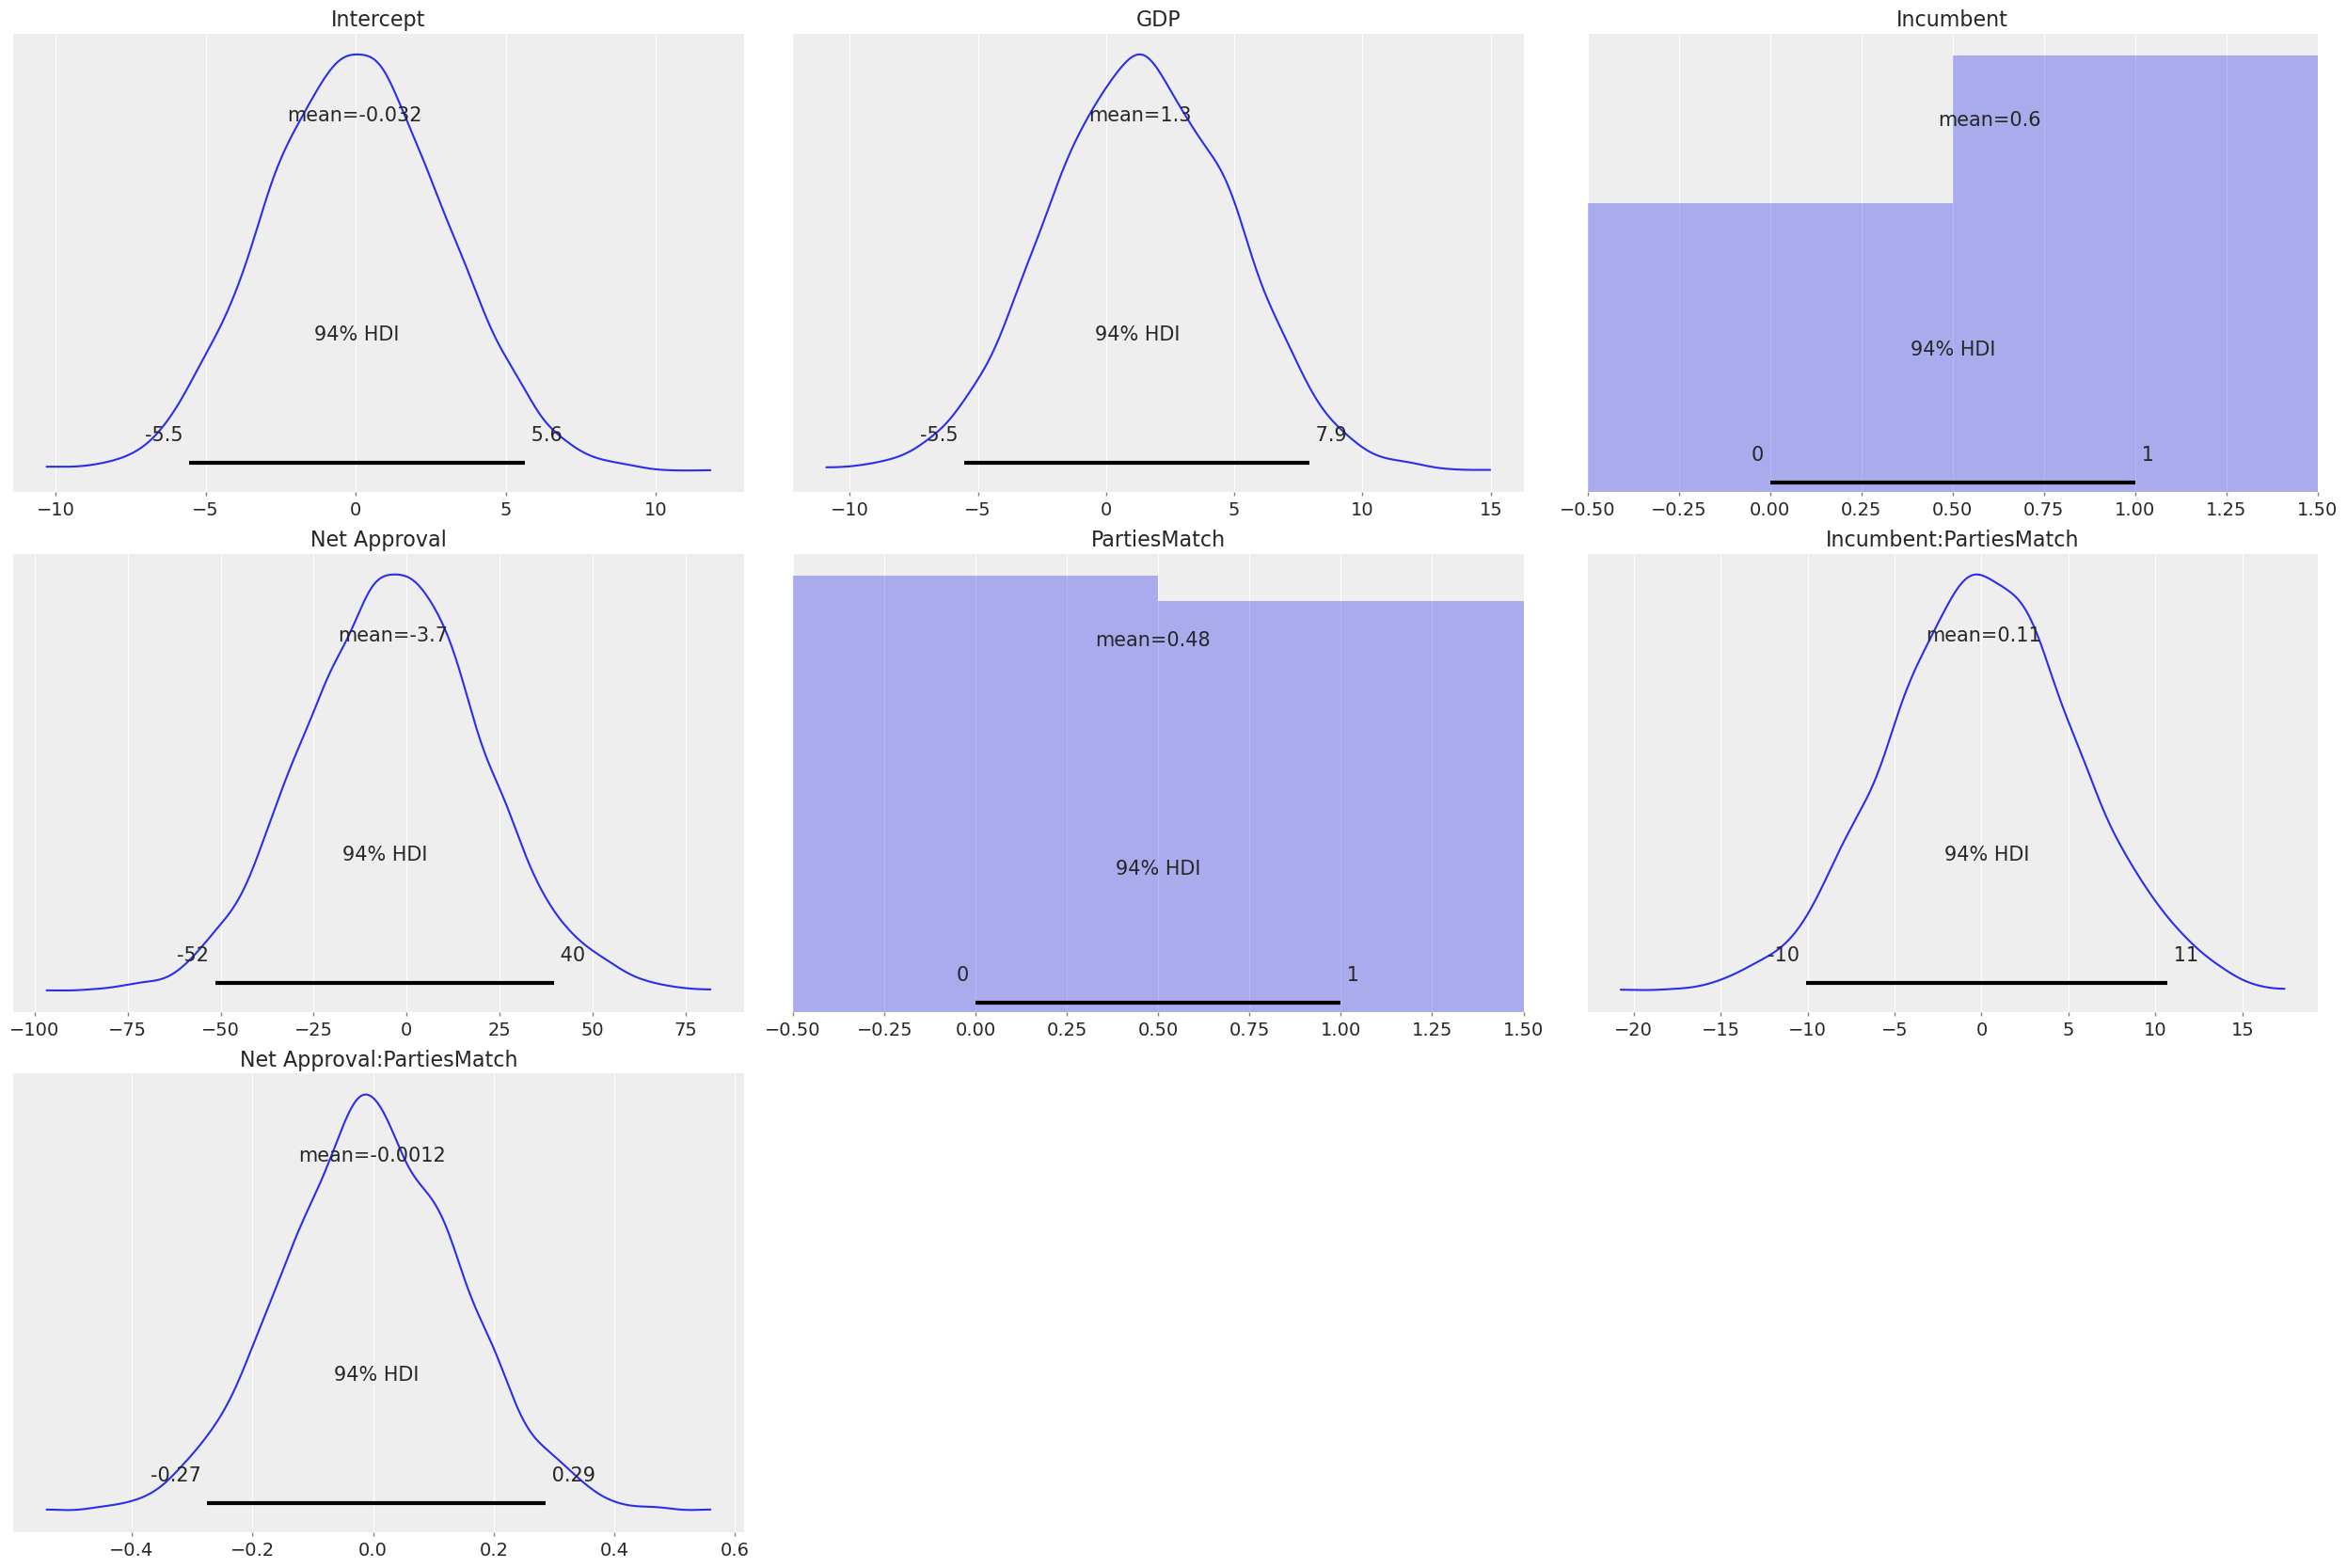

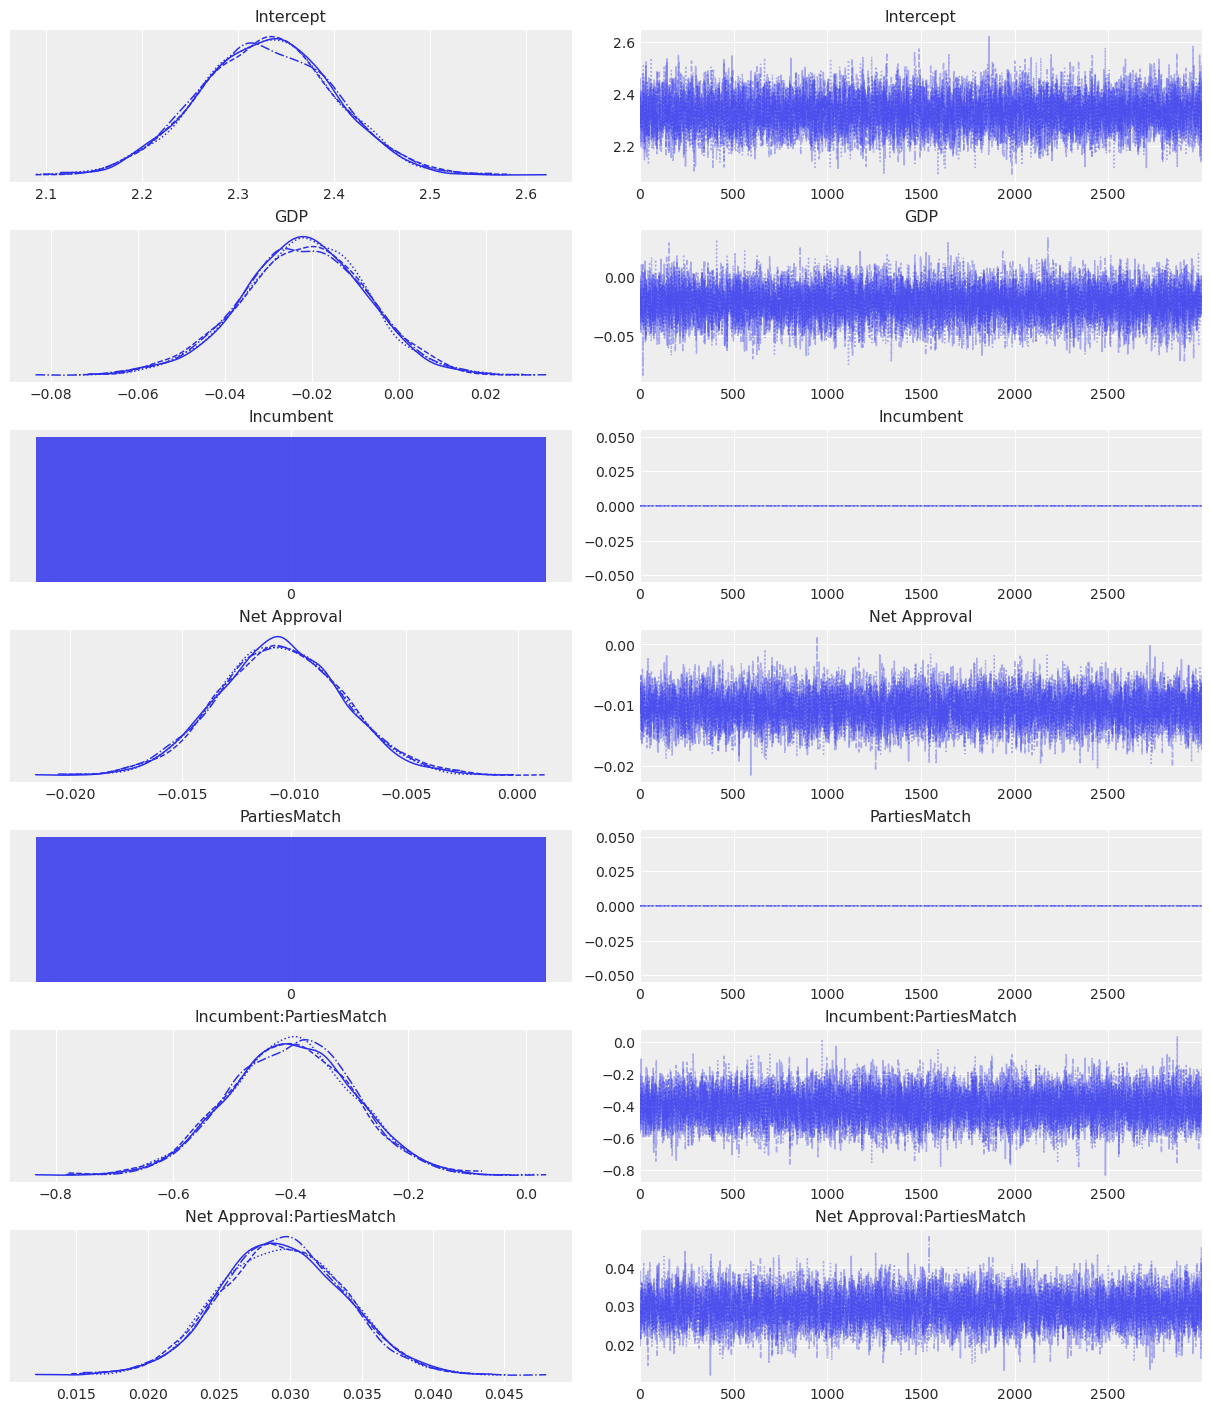

In [24]:
house_district_classifier_model.plot_priors()
az.plot_trace(house_district_classifier_model_results)
house_district_classifier_model_summary = az.summary(house_district_classifier_model_results)
house_district_classifier_model_summary

In [25]:
house_district_classifier_model_results

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

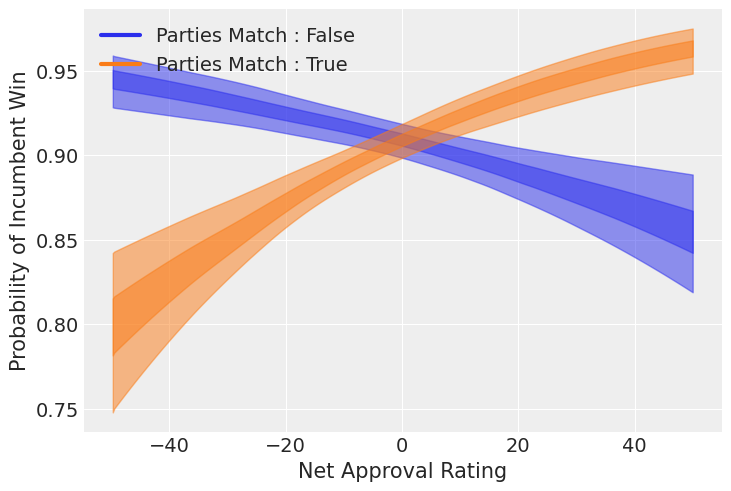

In [47]:
APPROVAL = np.linspace(-50, 50)


fig, ax = plt.subplots()
handles = []
for i in range(2):
    color = f"C{i}"
    label = f"Parties Match : {bool(i)}"
    handles.append(mlines.Line2D([], [], color=color, label=label, lw=3))

    new_data = pd.DataFrame({
           'GDP': np.ones_like(APPROVAL) * (congressional_district_data['GDP'].mean()),
           'Incumbent': np.ones_like(APPROVAL) * 0,
           'Net Approval': APPROVAL,
           'PartiesMatch': np.ones_like(APPROVAL) * i
    })
    new_idata = house_district_classifier_model.predict(house_district_classifier_model_results,
                                                        data=new_data,
                                                        kind='mean',
                                                        inplace=False)
    mean = new_idata.posterior["HouseIncumbentWon_mean"].values

    az.plot_hdi(APPROVAL, mean, ax=ax, color=color)
    az.plot_hdi(APPROVAL, mean, ax=ax, color=color, hdi_prob=0.5)

ax.set_xlabel("Net Approval Rating")
ax.set_ylabel("Probability of Incumbent Win")
ax.legend(handles=handles, loc="upper left")



In [55]:
test_predictions = house_district_classifier_model.predict(house_district_classifier_model_results, inplace=False)
test_means = test_predictions.posterior['HouseIncumbentWon_mean'].mean(axis=1).mean(axis=0).values
test_means = pd.Series(test_means)
test_means

0       True
1       True
2       True
3       True
4       True
        ... 
4345    True
4346    True
4347    True
4348    True
4349    True
Length: 4350, dtype: bool

In [53]:
congressional_district_data['HouseIncumbentWon']

0       True
1       True
2       True
3       True
4       True
        ... 
4345    True
4346    True
4347    True
4348    True
4349    True
Name: HouseIncumbentWon, Length: 4350, dtype: bool

In [63]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc_score(congressional_district_data['HouseIncumbentWon'], test_means)


0.595861870412242

In [64]:
roc_curve(congressional_district_data['HouseIncumbentWon'], test_means)


(array([0.        , 0.01698514, 0.04458599, 0.11252654, 0.12738854,
        0.15711253, 0.1910828 , 0.21656051, 0.30997877, 0.32696391,
        0.35456476, 0.39915074, 0.4522293 , 0.492569  , 0.64968153,
        0.66666667, 0.74522293, 0.76220807, 0.83014862, 0.93205945,
        1.        ]),
 array([0.        , 0.05362207, 0.11111111, 0.16421758, 0.21500387,
        0.25934519, 0.3070379 , 0.36478474, 0.4186646 , 0.46326373,
        0.51353442, 0.57231245, 0.61716937, 0.65919051, 0.70559423,
        0.75431812, 0.80433101, 0.86078886, 0.90899716, 0.95694767,
        1.        ]),
 array([1.95049326, 0.95049326, 0.93796977, 0.93428175, 0.9244573 ,
        0.9176299 , 0.9162702 , 0.9144589 , 0.90597248, 0.90492482,
        0.90424133, 0.90330315, 0.89138578, 0.86916909, 0.86776662,
        0.86689858, 0.86160513, 0.85991085, 0.84383328, 0.83328765,
        0.82361795]))